# RTL-Snow

Investigating the ADS-B sky during a snow storm using a RTL-SDR sofware defined radio

In [2]:
import os
import glob
import LatLon 
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 5)

# plot
%matplotlib inline
import pylab
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.collections
from pysurvey.plot import setup, legend, icolorbar, density

# date
from dateutil import parser
from matplotlib.dates import date2num

# database
import dataset
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

# Load Data

  * Original decision was to store the data straight to disk as flat text files.
  * This lower the load on the pi, so lets grab the right columns, and build up a large ~200MB dataframe

In [4]:
filenamepattern = '/Users/ajmendez/tmp/flight_data/locations_*.log'
data = None
for i, filename in enumerate(glob.glob(filenamepattern)):
    tmp = pd.read_csv(filename, skiprows=1, usecols=[4,6,7,11,14,15], 
                     names='flight date time alt lat lon'.split())
    if data is None:
        data = tmp
#         break
    else:
        data =  pd.concat([data, tmp], ignore_index=True)

In [5]:
data

flight        date          time    alt       lat       lon
0        AA9249  2016/01/15  02:24:21.604   8625  39.12570 -77.53583
1        AA9249  2016/01/15  02:24:22.969   8675  39.12730 -77.53491
...         ...         ...           ...    ...       ...       ...
2208973  A9A97F  2016/01/31  12:42:23.321  36000  40.36322 -76.64349
2208974  A9A97F  2016/01/31  12:42:24.898  36000  40.36279 -76.64712

[2208975 rows x 6 columns]

# Create Tags (data features)

  * flightnum -- unique flight number
  * datenum -- the number of days since the start
  * distance -- distance away from antenna
  * heading -- angle from north for plane
  * x,y -- rotated coordinates for easy plots

In [6]:
# Check multidimensional issues
for i in data.index:
    assert len(data['lon'][i].shape) == 0, IndexError('Multidimension issue -- check files')

In [7]:
tmp = {flight:i for i,flight in enumerate(sorted(np.unique(data['flight'])))}
data['flightnum'] = data['flight'].map(tmp)

In [8]:
# datenum is the number of days since the 
tmp = (data['date']+' '+data['time']).apply(parser.parse)
data['datenum'] = tmp.apply(date2num)
data['datenum'] -= data['datenum'].min()

In [9]:
data['hour'] = (data['datenum'] % 1)*24
data['weekday'] = (data['datenum'] % 7).apply(np.int)
data['normtime'] = data['datenum']/data['datenum'].max()

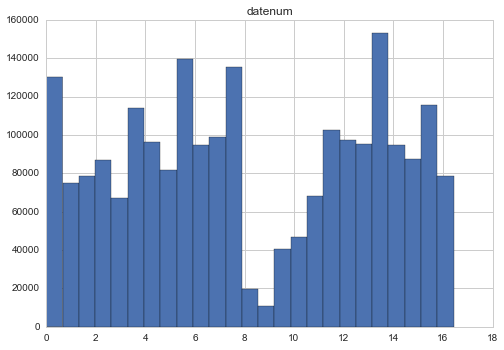

In [10]:
_ = data.hist('datenum', bins=25)
# You can clearly see the effects of snow on flights in the north and east of Baltimore City

In [11]:
# initial heading, distance to each point from the antenna
ant = LatLon.LatLon(39.331832, -76.623450)
def get_heading_distance(tmp):
    heading, distance = np.zeros( (2, tmp.shape[0]) )
    for i in tmp.index:
        try:
            loc = LatLon.LatLon(tmp['lat'][i],tmp['lon'][i])
        except Exception as e:
            print i, tmp['lat'][i],tmp['lon'][i]
            raise
        heading[i] = ant.heading_initial(loc)
        distance[i] = ant.distance(loc)
    return heading, distance

data['heading_deg'], data['distance'] = get_heading_distance(data[['lat', 'lon']])
data['heading']  = np.deg2rad(data['heading_deg'])
# Keep degree heading for filtering below
data.loc[data['heading_deg']<0, 'heading_deg'] += 360

In [12]:
def setup_polarplot(subplt=111):
    ax = pylab.subplot(subplt, projection='polar')
    ax.set_theta_direction(-1)
    ax.set_theta_zero_location('N')
    ax.set_xlabel('heading')
    ax.set_ylabel('direction [km]')
    return ax

def get_paths(ax):
    for item in ax.get_children():
        if isinstance(item, matplotlib.collections.PathCollection):
            return item


<matplotlib.colorbar.Colorbar instance at 0x140be3830>

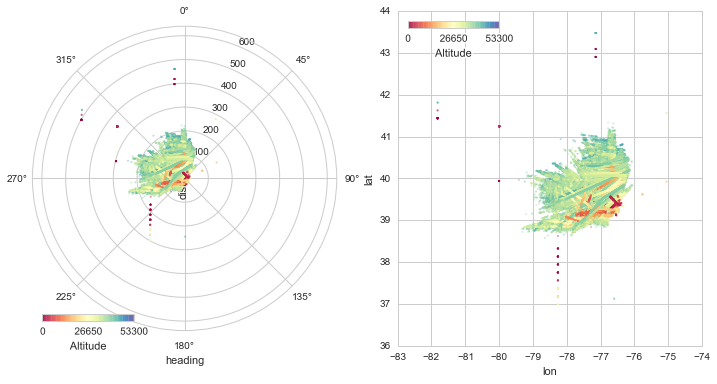

In [18]:
tmp =  data[data['distance'] < 1000] # inital cleaning
pylab.figure(figsize=(12,6))
p = tmp.plot('heading', 'distance', 'scatter', c='alt', 
             colorbar=False, cmap=pylab.cm.Spectral, 
             ax=setup_polarplot(121),
             s=4, edgecolor='none', alpha=0.4)
icolorbar(get_paths(p), loc=3, label='Altitude')

p = tmp.plot('lon', 'lat', 'scatter', c='alt', 
             colorbar=False, cmap=pylab.cm.Spectral, 
             ax=pylab.subplot(122), s=4, edgecolor='none', alpha=0.4)
icolorbar(get_paths(p), loc=2, label='Altitude')

In [19]:
from mpl_toolkits.axes_grid.axislines import SubplotZero
from matplotlib.ticker import MultipleLocator, FuncFormatter

def setup_polar(subplt=111):
    fig = pylab.gcf()
    ax = SubplotZero(fig, subplt)
    fig.add_subplot(ax)
    for d in ax.axis:
        ax.axis[d].set_visible(d.endswith("zero"))
    tick_format = lambda x, i: '' if x == 0.0 else '%.0f' % x
    for a in [ax.xaxis, ax.yaxis]:
        a.set_minor_locator(MultipleLocator(10))
        a.set_major_formatter(FuncFormatter(tick_format))
    for r in range(0,200,25):
        lab = '{:0.0f} km'.format(r)
        if r == 0:
            lab='home'
    #     text(-r*np.cos(45),-r*np.sin(45),lab, clip_on=True,
    #          va='center', ha='center', outline=True)
        ax.add_artist(pylab.Circle((0,0), r, alpha=1-r/200.0,
                                   facecolor='none', edgecolor='r'))
    return ax


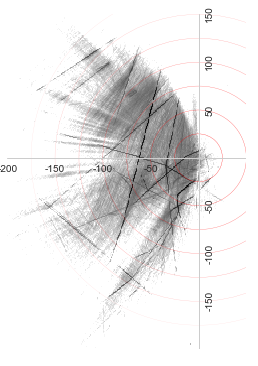

In [20]:
theta = -data['heading'] + 3*np.pi/4.
data['x'] = data['distance'] * np.cos(theta)
data['y'] = data['distance'] * np.sin(theta)

pylab.figure(figsize=(6,6))
ax = setup_polar()
density(data['x'], data['y'], 
        extent=[-200,50,-200,150], label='Log num aircraft', nbins=300, ax=ax,
        logvrange=True, colorbar=False, cmap=pylab.cm.Greys)
ax.set_aspect('equal')
ax.grid('off', axis='y')

# Clean Data

  * There are a bunch of very odd records. Some of these are due to being able to "observe" planes at to the airport so that their GPS signal is quite bad.

(1860230, 16)


<matplotlib.colorbar.Colorbar instance at 0x140e74dd0>

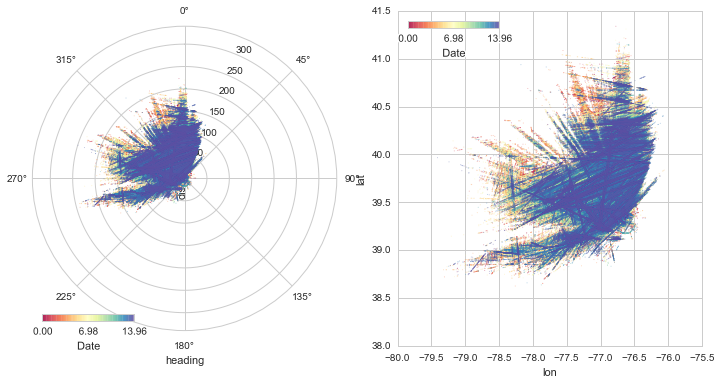

In [22]:
clean =  data[ # Distant Points are are inaccurate
               (data['distance'] < 250) &
               # Look at just two weeks
               (data['datenum'] < 14) &
               # Better filter lat/lon
               (data['lat'] > 38.5) & (data['lat'] < 42) & 
               (data['lon'] > -79.9) & (data['lon'] < -76) &
               # Odd string of points on the left
                ~( (data['heading_deg'] < 240)  &
                   (data['heading_deg'] > 180)  &
                   (data['distance'] > 150)  )
            ]
print clean.shape
color = clean['datenum']/clean['datenum'].max()
pylab.figure(figsize=(12,6))
p = clean.plot('heading', 'distance', 'scatter', 
           c='datenum', cmap=pylab.cm.Spectral, colorbar=False,
           ax=setup_polarplot(121), s=1, edgecolor='none', alpha=0.4)
icolorbar(get_paths(p), loc=3, label='Date')

p = clean.plot('lon','lat', 'scatter', c='datenum', cmap=pylab.cm.Spectral, colorbar=False,
           ax=pylab.subplot(122), s=1, edgecolor='none', alpha=0.4)
icolorbar(get_paths(p), loc=2, label='Date')

## Quick Look

<matplotlib.colorbar.Colorbar instance at 0x11b26d050>

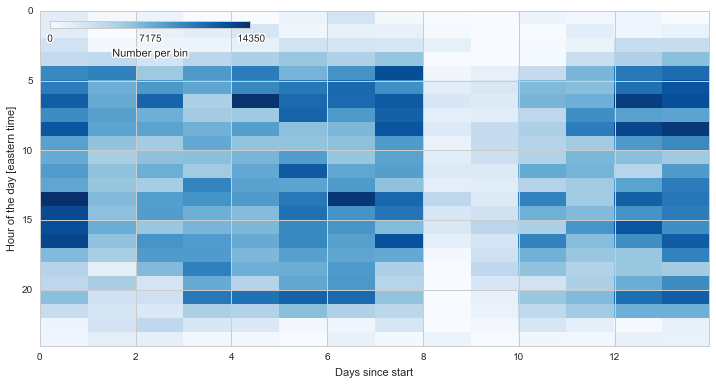

In [24]:
pylab.figure(figsize=(12,6))
pylab.xlabel('Days since start')
pylab.ylabel('Hour of the day [eastern time]')
pylab.ylim(24,0)
den = density(clean['datenum'], clean['hour'], 
              nbins=[14,24], label='Number per bin',
              cmap=pylab.cm.Blues, colorbar=False, )
icolorbar(den)

Number Before: 317,198. Number during:67,827. Number after: 358,676


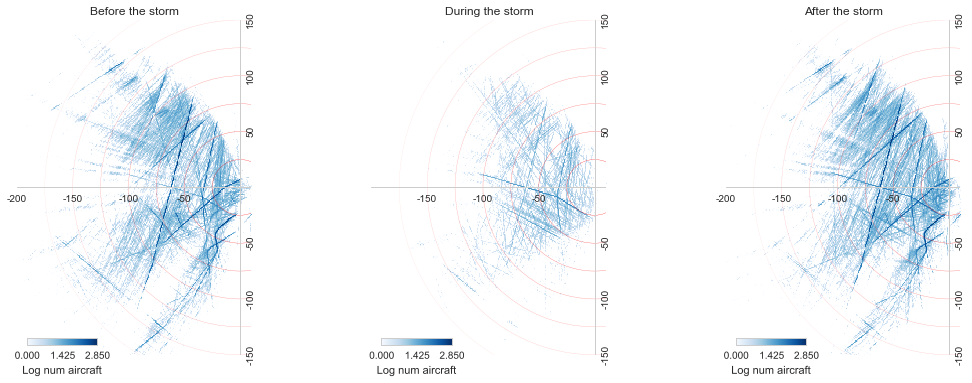

In [25]:
def plot_density(cat, ax):
    den = density(cat['x'], cat['y'],
                  extent=[-200,10,-150,150], label='Log num aircraft', nbins=300, ax=ax,
                  vmin=0, vmax=2.85,
                  logvrange=True, colorbar=False, cmap=pylab.cm.Blues)
    icolorbar(den, loc=3)
    ax.set_aspect('equal')
    ax.grid('off', axis='y')
    return den

    

pylab.figure(figsize=(18,6))

# Before the storm
before = clean[(clean['datenum']>4) & (clean['datenum']<6)]
plot_density(before, ax=setup_polar(131))
pylab.title('Before the storm')


# During the storm
during = clean[(clean['datenum']>8) & (clean['datenum']<10)]
plot_density(during, ax=setup_polar(132))
pylab.title('During the storm')

# After the storm
after = clean[(clean['datenum']>12) & (clean['datenum']<14)]
plot_density(after, ax=setup_polar(133))
pylab.title('After the storm')

print('Number Before: {:,d}. Number during:{:,d}. Number after: {:,d}'
      .format(len(before), len(during), len(after)))

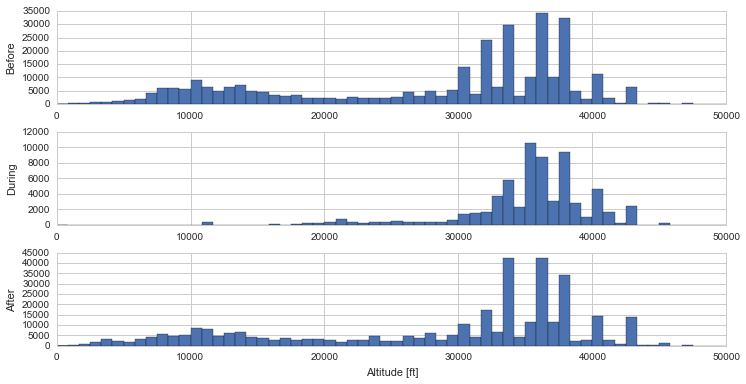

In [26]:
pylab.figure(figsize=(12,6))
bins = np.linspace(0,50000, 61)
before.hist('alt', bins=bins, ax=pylab.subplot(311))
pylab.title('')
pylab.ylabel('Before')

during.hist('alt', bins=bins, ax=pylab.subplot(312))
pylab.title('')
pylab.ylabel('During')

after.hist('alt', bins=bins, ax=pylab.subplot(313))
pylab.title('')
pylab.xlabel('Altitude [ft]')
pylab.ylabel('After')

There are very few low altitude flights (alt<20000ft) during the storm. 
These are flights headed to or from BWI.

## Checkpoint Data

Save the cleaned data to disk to limit recomputation of the data

In [27]:
if False:
    data.to_csv('/Users/ajmendez/tmp/flight/flight_data.csv')
    clean.to_csv('/Users/ajmendez/tmp/flight/flight_clean.csv')
    before.to_csv('/Users/ajmendez/tmp/flight/flight_before.csv')
    during.to_csv('/Users/ajmendez/tmp/flight/flight_during.csv')
    after.to_csv('/Users/ajmendez/tmp/flight/flight_after.csv')

In [2]:
try:
    _ = len(data)
    print "already in mem"
except:
    data = pd.DataFrame.from_csv('/Users/ajmendez/tmp/flight/flight_data.csv')
    clean = pd.DataFrame.from_csv('/Users/ajmendez/tmp/flight/flight_clean.csv')
    before = pd.DataFrame.from_csv('/Users/ajmendez/tmp/flight/flight_before.csv')
    during = pd.DataFrame.from_csv('/Users/ajmendez/tmp/flight/flight_during.csv')
    after = pd.DataFrame.from_csv('/Users/ajmendez/tmp/flight/flight_after.csv')
    print 'loaded!'

loaded!


## Predictions

* Lets try some machine learning algorithms to predict the future. 
* (1) Predict plane identifier using location and hour: Use the before-storm data to train a model to predict the after-storm planes.
* (2) Determine which planes are landing at BWI by which are canceled

In [218]:
clean_tags = ['flight', 'date', 'time', 'weekday', 'normtime', #'datenum', 
#               'alt', 'distance', 'heading_deg', 'heading', 'x', 'y'
             ]
input_tags = ['lat', 'lon', 'hour']
before_simple = before[before['alt'] < 20000].drop(clean_tags, axis=1)
after_simple = after[after['alt'] < 20000].drop(clean_tags, axis=1)

before_simple

alt       lat       lon  flightnum   datenum       hour  \
555452  19975  39.90788 -76.57513       2804  4.083520   2.004485   
555453  19975  39.90756 -76.57704       2804  4.083526   2.004627   
...       ...       ...       ...        ...       ...        ...   
870159  16175  39.10835 -77.00293       2065  5.926931  22.246340   
870160  16225  39.10779 -77.00024       2065  5.926944  22.246651   

        heading_deg   distance   heading          x          y  
555452     3.696297  64.091509  0.064513 -42.303614  48.146918  
555453     3.552561  64.045640  0.062004 -42.393904  48.006259  
...             ...        ...       ...        ...        ...  
870159   232.990672  41.103616 -2.216731  -5.713891 -40.704529  
870160   232.724426  40.956478 -2.221378  -5.504905 -40.584839  

[85293 rows x 11 columns]

In [219]:
len(before), len(before_simple), len(after), len(after_simple)

(317198, 85293, 358680, 91120)

In [198]:
from sklearn import cross_validation
from sklearn import ensemble

In [215]:
random_forest = ensemble.RandomForestClassifier(random_state=0, n_estimators=100, 
                                                criterion='gini', min_samples_split=100, min_samples_leaf=5)
random_forest.fit(before_simple[input_tags], before_simple['flightnum'])
random_forest.score(before_simple[input_tags], before_simple['flightnum'])

0.92238518987490181

In [216]:
random_forest.score(after_simple[input_tags], after_simple['flightnum'])
# well that did not work at all.

0.012719490781387182

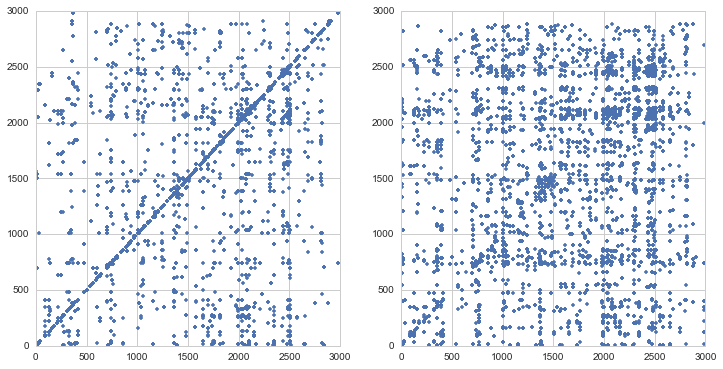

In [217]:
pylab.figure(figsize=(12,6))
pylab.subplot(121)
before_flightnum = random_forest.predict(before_simple[input_tags])
pylab.plot(before_flightnum, before_simple['flightnum'], '.')

pylab.subplot(122)
after_flightnum = random_forest.predict(after_simple[input_tags])
pylab.plot(after_flightnum, after_simple['flightnum'], '.')

In [200]:
gradient_boost = ensemble.GradientBoostingClassifier(random_state=0)
gradient_boost.fit(before_simple[input_tags], before_simple['flightnum'])
gradient_boost.score(before_simple[input_tags], before_simple['flightnum'])

1.0

In [201]:
gradient_boost.score(after_simple[input_tags], after_simple['flightnum'])

0.00059999999999999995

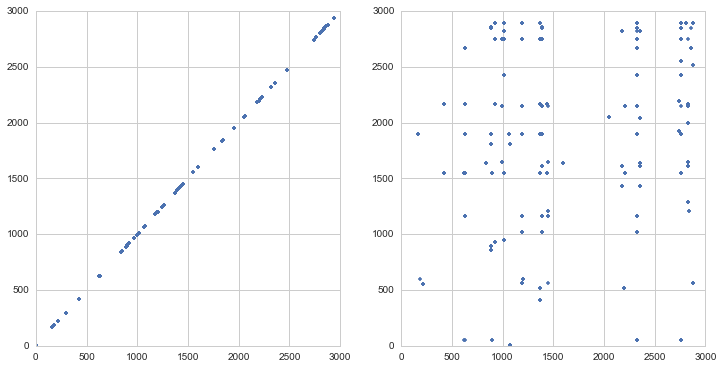

In [202]:
pylab.figure(figsize=(12,6))
pylab.subplot(121)
before_flightnum = gradient_boost.predict(before_simple[input_tags])
pylab.plot(before_flightnum, before_simple['flightnum'], '.')

pylab.subplot(122)
after_flightnum = gradient_boost.predict(after_simple[input_tags])
pylab.plot(after_flightnum, after_simple['flightnum'], '.')

In [204]:
extra_trees = ensemble.ExtraTreesClassifier(random_state=0, n_estimators=100, max_depth=None, min_samples_split=10)
extra_trees.fit(before_simple[input_tags], before_simple['flightnum'])
extra_trees.score(before_simple[input_tags], before_simple['flightnum'])

1.0

In [205]:
extra_trees.score(after_simple[input_tags], after_simple['flightnum'])

0.0114

In [15]:
scores = cross_validation.cross_val_score(
    RandomForestClassifier(
        random_state=0,
        n_estimators=150,
        min_samples_split=4,
        min_samples_leaf=2
    ),
    before_simple[input_tags],
    before_simple['flightnum'],
    cv=3
)

print('{:0.1f}'.format(100*scores.mean()))

1.3


/Users/ajmendez/.local/canopy/User/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


# Better classifier(s) needed

After the training we are not able to predict the after storm dataset.  After bumping up the number of samples to 10k, still not getting optimal results.  Trying full sample using a few classifiers and a much larger machine than my laptop.

In [16]:
#!/usr/bin/env python

import pickle
import pandas as pd
from sklearn import svm, ensemble
from sklearn.externals import joblib

def main():
    print 'loading...'
    input_tags = ['lat', 'lon', 'hour']
    before = pd.DataFrame.from_csv('flight_before.csv')
    
    sv = svm.SVC(random_state=0, verbose=True)
    print 'svm fitting...'
    sv.fit(before[input_tags], before['flightnum'])
    joblib.dump(sv, 'flight_before_svc.pkl')
    print 'done!'
    
    
    rf = ensemble.RandomForestClassifier(random_state=0, n_estimators=100, criterion='entropy', verbose=True, n_jobs=10)
    print 'rf fitting...'
    rf.fit(before[input_tags], before['flightnum'])
    joblib.dump(rf, 'flight_before_rf.pkl')
    print 'done!'
    
    
    print 'gb fitting...'
    gb.fit(before[input_tags], before['flightnum'])
    joblib.dump(gb, 'flight_before_gb.pkl')
    print 'done!'
    
    

if __name__ == '__main__':
    main()

# Support Vector Machines

In [6]:
from sklearn.externals import joblib

In [7]:
sv = joblib.load('/Users/ajmendez/tmp/flight/flight_before_svc.pkl') 

In [ ]:
before_score = sv.score(before_simple[input_tags], before_simple['flightnum'])
after_score = sv.score(after_simple[input_tags], after_simple['flightnum'])
print 'Before score: {:.1f}. After score: {:0.1f}'.format(before_score*100, after_score*100)

# Geographic Pattern

The asymmetric pattern on the sky is due partially from the location of the antenna on the northern / western side of the building.

In [19]:
import geoplotlib
from geoplotlib.utils import read_csv, BoundingBox
from IPython.display import Image

In [72]:
pname = '/Users/ajmendez/tmp/flight.png'
# geoplotlib.tiles_provider('darkmatter')

geoplotlib.kde(before_simple, bw=[0.5,0.5], cut_below=1e-6, alpha=140, cmap='coolwarm')
# bbox = BoundingBox(40.9,-77.8,38.7,-78.1)
bbox = geoplotlib.utils.BoundingBox.from_points(before_simple['lon'], before_simple['lat'])
geoplotlib.set_bbox(bbox)

geoplotlib.set_window_size(800, 800)


geoplotlib.show()
# geoplotlib.savefig(pname.replace('.png',''))
# Image(pname)

('smallest non-zero count', 6.9624781887990752e-08)
('max count:', 248.59835843254379)
('smallest non-zero count', 6.9624781887990752e-08)
('max count:', 248.59835843254379)


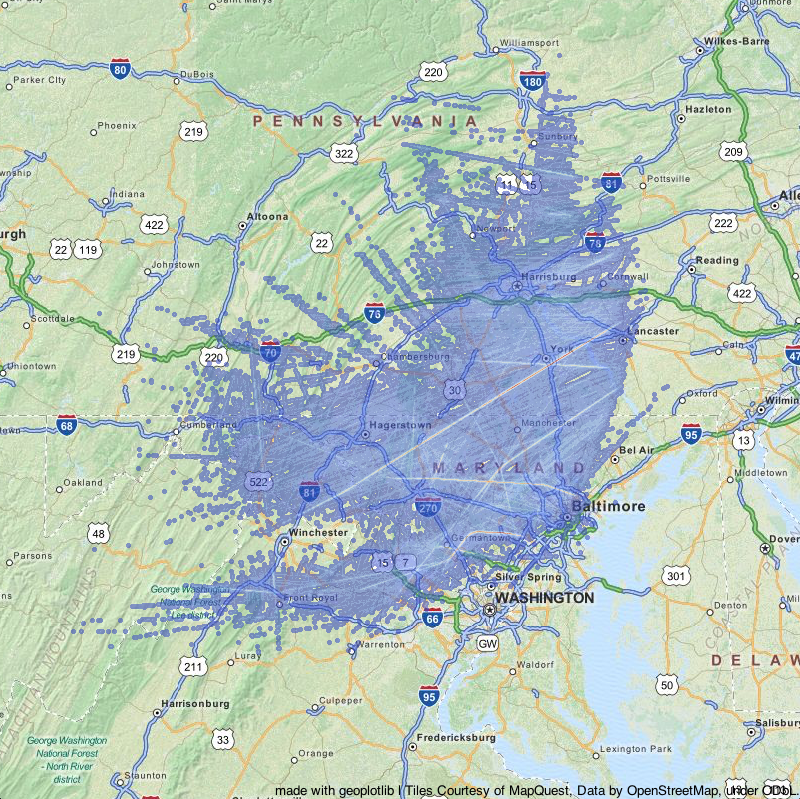

In [73]:
Image('/Users/ajmendez/Desktop/Screen Shot 2016-02-15 at 4.26.27 PM.png')

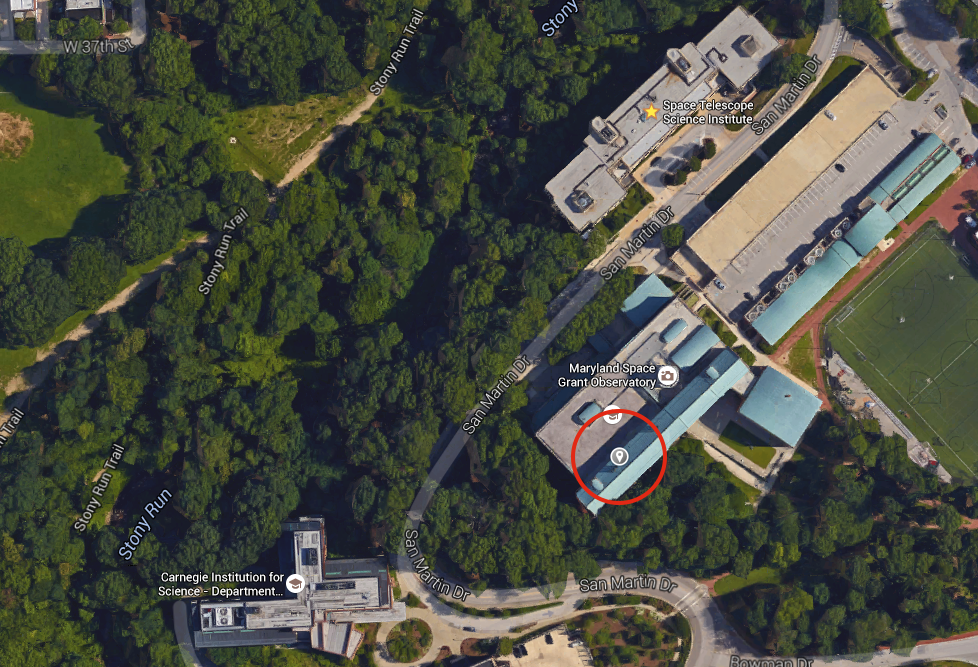

In [20]:
Image('/Users/ajmendez/Desktop/Screen Shot 2016-02-15 at 4.11.51 PM.png')

# Save Data

In [28]:
# save it as a db for other things.
# db = dataset.connect('sqlite:///Users/ajmendez/flight.db')
engine = create_engine('sqlite:////Users/ajmendez/flight.db')
if not database_exists(engine.url):
    create_database(engine.url)

with engine.connect() as conn, conn.begin():
    clean.to_sql('clean', engine)
